In [1]:
%config IPCompleter.greedy=True
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt


Using TensorFlow backend.


## PART B - Keras – High Level API [30 Marks]

The objective of Part B is to explore the problem of image classification when using a dataset a dataset that contains images of letters from A – J inclusive. A sample of some of the images are depicted in the image below.
We will be working with a modified version of the original dataset. Some pre-processing work has been completed on the dataset and it has also been normalized.

In [2]:
#From appendix of assignment brief
def loadData():
    with h5py.File('data/data.h5','r') as hf:
        print('List of arrays in this file: \n', hf.keys())
        allTrain = hf.get('trainData')
        allTest = hf.get('testData')
        npTrain = np.array(allTrain)
        npTest = np.array(allTest)
    print('Shape of the array dataset_1: \n', npTrain.shape)
    print('Shape of the array dataset_2: \n', npTest.shape)
    return npTrain[:,:-1], npTrain[:, -1], npTest[:,:-1], npTest[:, -1]

trainX, trainY, testX, testY = loadData()
outputs = []

List of arrays in this file: 
 <KeysViewHDF5 ['testData', 'trainData']>
Shape of the array dataset_1: 
 (200000, 785)
Shape of the array dataset_2: 
 (17000, 785)


In [3]:
def visualiseOutput(history, results):
    print("\n")
    print("Test Loss: ", results[0])
    print("Test Accuracy: ", results[1])
    print("\n")
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
   
    plt.title('Training Loss and Accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch #')
    plt.legend(['train loss', 'val loss', 'train acc', 'val acc'], loc='lower left')
    plt.show()

In [4]:

'''
This base function will be used through this notebook to build keras NN.
I have decided to generalise the creation of networks to avoid substantial code duplication as well as 
to make it more readable.
This methos will take the list of layers to be created and will return compiled model.
Function will be used in parts i and ii.
'''
def buildModel(layersList):
    #MultiGPU execution, may need to be removed if running on other environment
    #https://www.tensorflow.org/guide/distributed_training
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = tf.keras.models.Sequential()
        model.add(layers.InputLayer(input_shape=(784,)))
        for layer in layersList:
            model.add(layers.Dense(layer["size"], activation=layer["activation"]))
            if layer["applyDropout"]:
                model.add(layers.Dropout(layer["dropRate"]))
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        return model

In [5]:
def executeModel(hidden):
    layers = []
    for layer in hidden:
        layers.append({"size": layer[0], "activation": tf.nn.relu, "applyDropout": layer[1], "dropRate": layer[2]})
    layers.append({"size": 10, "activation": tf.nn.softmax, "applyDropout": False, "dropRate": 0.3})
    model = buildModel(layers)
    history = model.fit(trainX, trainY, epochs=20, batch_size=256, validation_split=0.1, verbose=0)
    results = model.evaluate(testX, testY, verbose=0)
    outputs.append(results)
    return history, results

##### Part B (i)

The initial task for part 2 is to use Keras to build a SoftMax classifier. This will serve as a benchmark for the work below. You should be able to achieve an accuracy of approximately 85% on the test data. Specify a batch size of 256 when building your model.



Test Loss:  0.5475715282384087
Test Accuracy:  0.8554706




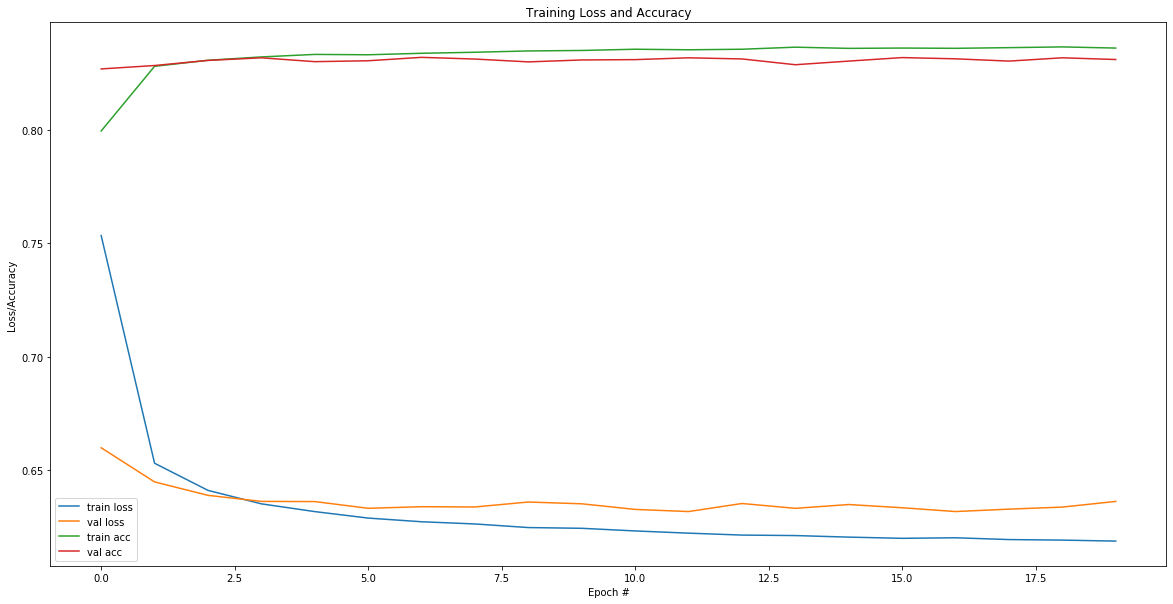

In [6]:
'''
Initial network consisting only of 1 Softmax layer
Given that there are letters A-J, there are 10 categories
'''
def initialTask():
    layers = []
    #input task for the model builder
    layers.append({"size": 10, "activation": tf.nn.softmax, "applyDropout": False, "dropRate": 0.0})
    model = buildModel(layers)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #capture history and results
    history = model.fit(trainX, trainY, epochs=20, batch_size=256, validation_split=0.1, verbose=0)
    results = model.evaluate(testX, testY, verbose=0)
    #visualise the outcome   
    visualiseOutput(history, results)
 

initialTask()

Next using Keras build a two layer fully-connected neural network with a single layer of ReLU activation neurons connected to a Softmax layer. Is there an improvement in accuracy over the SoftMax model?



Test Loss:  0.3331471808377434
Test Accuracy:  0.91552943




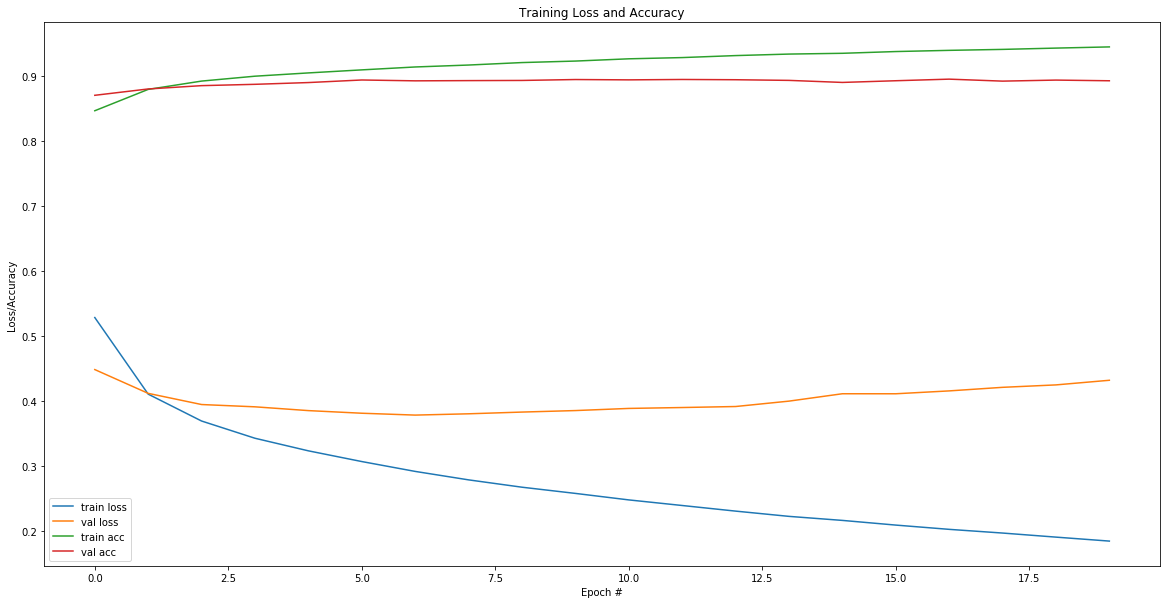

In [7]:
'''
Network consisting of 2 layers:
    1. 200 neuron Relu layer
    2. 10 neuron Softmax layer
'''
def twoLayers():
    layers = []
    #Prepare task for model builder
    layers.append({"size": 200, "activation": tf.nn.relu, "applyDropout": False, "dropRate": 0.0})
    layers.append({"size": 10, "activation": tf.nn.softmax, "applyDropout": False, "dropRate": 0.0})
    model = buildModel(layers)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #Capture results and history, verbose is off to save space
    #90/10 split between train and validation
    history = model.fit(trainX, trainY, epochs=20, batch_size=256, validation_split=0.1, verbose=0)
    results = model.evaluate(testX, testY, verbose=0)
    #Visualise   
    visualiseOutput(history, results)
 

twoLayers()

Examine the application of a deeper neural network to your problem (evaluate with 3, 4, 5 layers).

A comprehensive investigation of the network architecture is beyond the scope of this assignment. However, you should compare and contrast the performance of at least three different network configurations such as the following:

- L1 200 Neurons L2 Softmax
- L1 400 Neurons L2 200 Neurons L3 Softmax
- L1 600 Neurons L2 400 Neurons L3 200 Neurons L4 Softmax

In [8]:
'''
Reference: https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
'''
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [9]:
def executeModels(tasks):
    
    labels = []
    losses = []
    accuracies = []
    for task in tasks:
        networkLength = len(task) + 1
        print("\nExecuting model with {} layers:".format( networkLength ))
        h, r = executeModel(task)
        labels.append(str(networkLength) + " Layers")
        losses.append(round(r[0], 4))
        accuracies.append(round(r[1], 4))
        #Visualise   
        visualiseOutput(h, r)
        print("Executed model with {} layers. \n".format( networkLength ))


    fig, ax = plt.subplots(figsize=(20,10))
    x = np.arange(len(labels))
    width = 0.35
    rects1 = ax.bar(x - width/2, losses, width, label='Loss')
    rects2 = ax.bar(x + width/2, accuracies, width, label='Accuracy')
    ax.set_ylabel('Loss / Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    autolabel(rects1, ax)
    autolabel(rects2, ax)
    
    plt.show()
    print("End task execution. \n\n")
    




Executing model with 6 layers:


Test Loss:  0.42073883020439057
Test Accuracy:  0.92864704




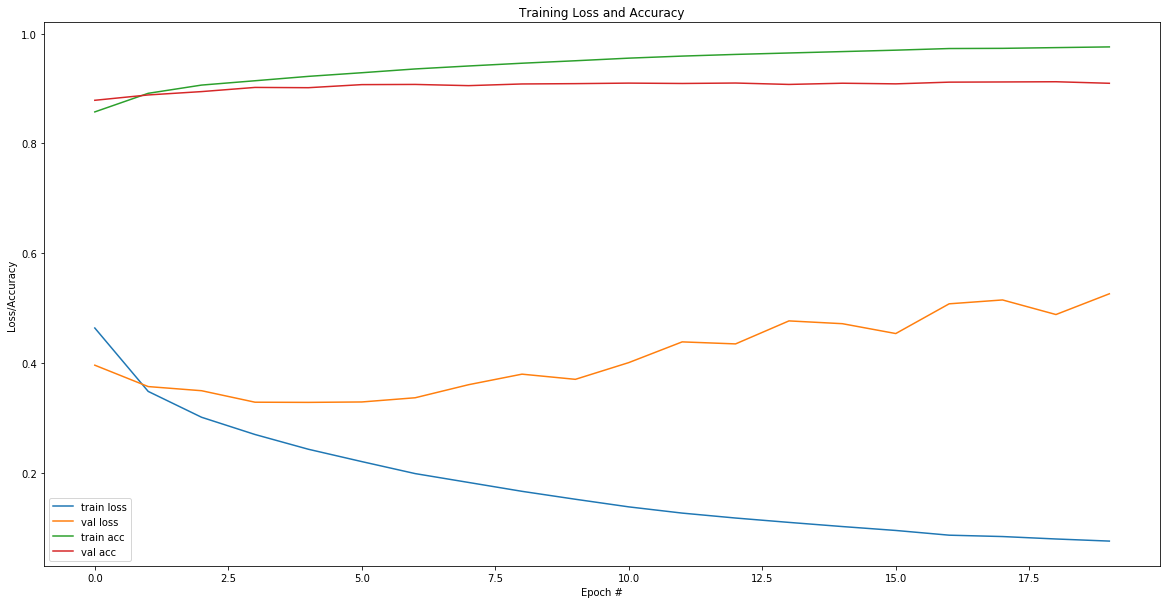

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.45143437909196743
Test Accuracy:  0.93041176




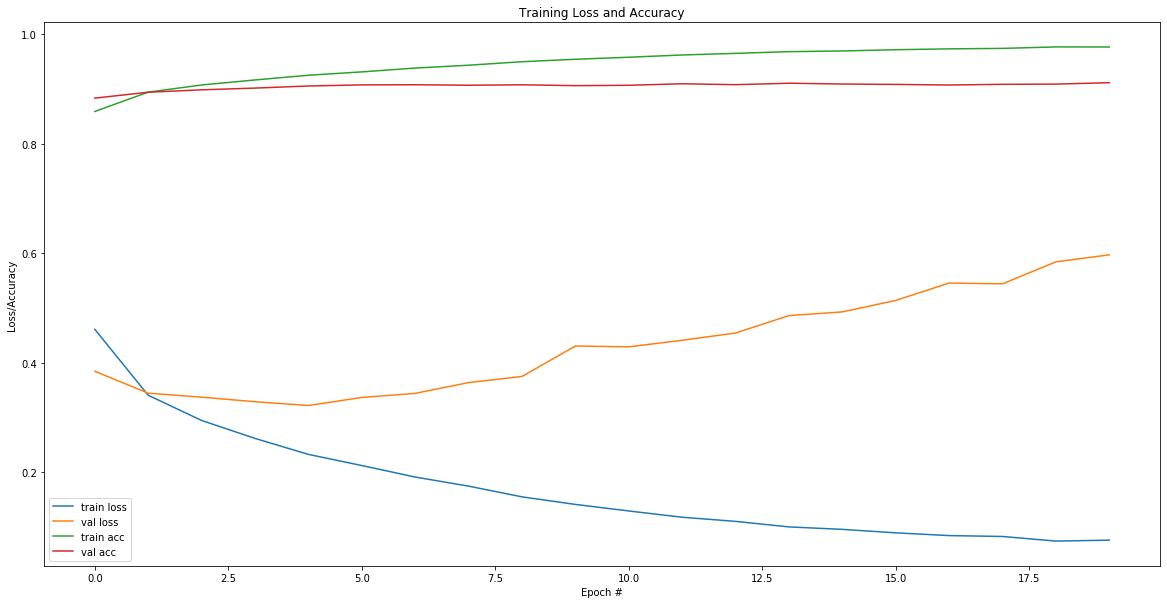

Executed model with 5 layers. 


Executing model with 4 layers:


Test Loss:  0.4860670519907495
Test Accuracy:  0.9242941




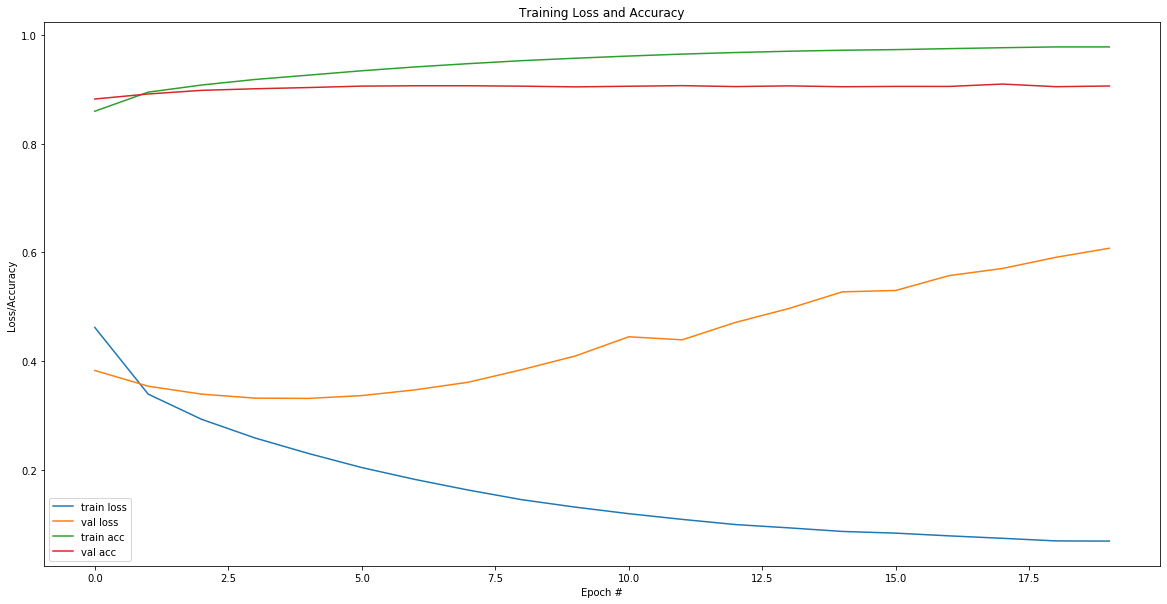

Executed model with 4 layers. 


Executing model with 3 layers:


Test Loss:  0.47141119469174436
Test Accuracy:  0.9207647




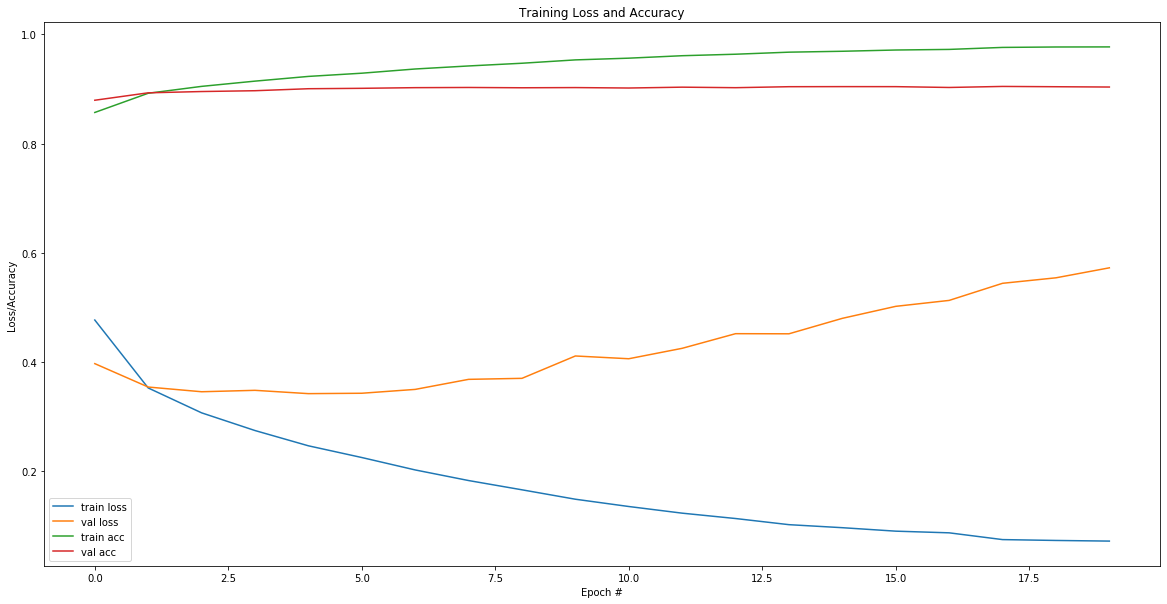

Executed model with 3 layers. 


Executing model with 2 layers:


Test Loss:  0.33998014602328047
Test Accuracy:  0.9115294




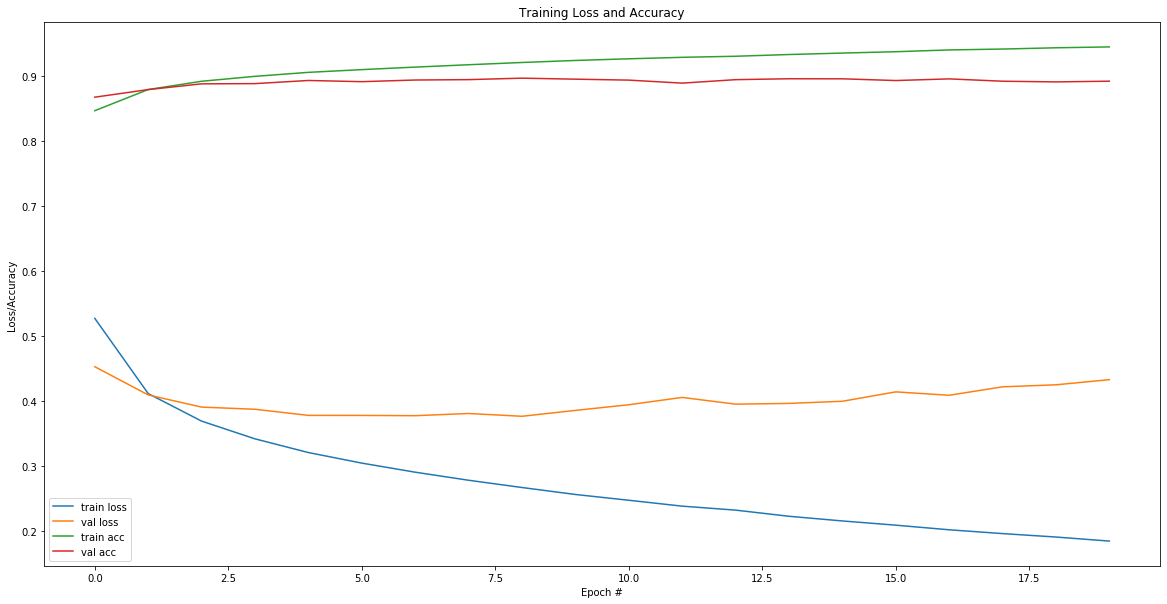

Executed model with 2 layers. 



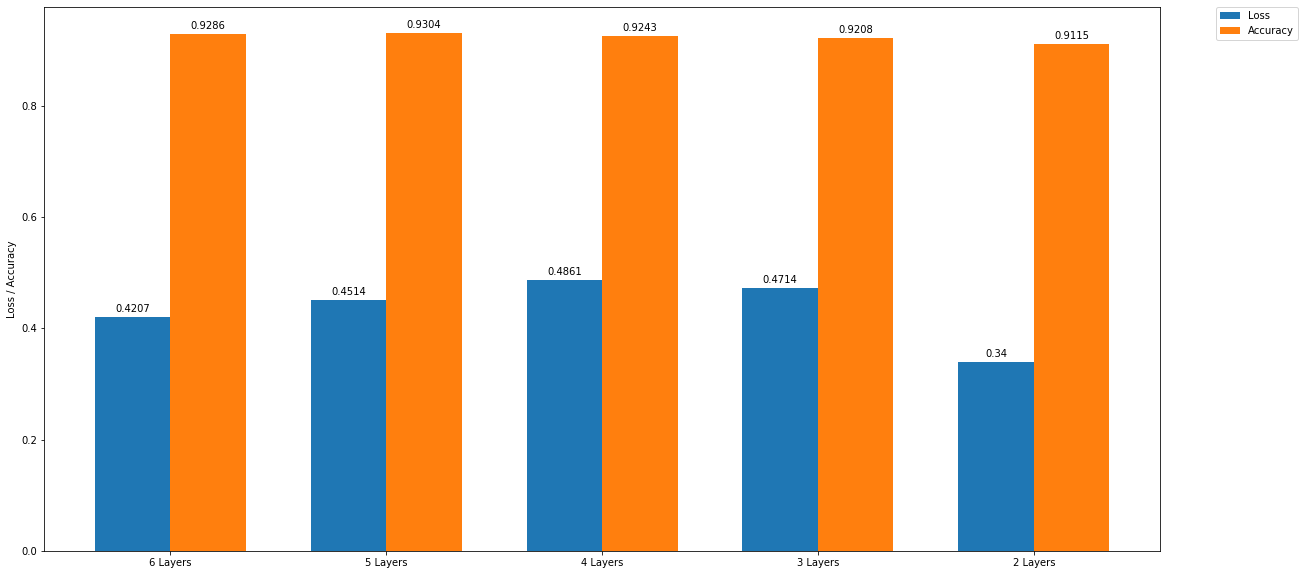

End task execution. 




In [10]:
tasks = []
tasks.append([[1000, False, 0], [800, False, 0], [600, False, 0], [400, False, 0], [200, False, 0]])
tasks.append([[800, False, 0], [600, False, 0], [400, False, 0], [200, False, 0]])
tasks.append([[600, False, 0], [400, False, 0], [200, False, 0]])
tasks.append([[400, False, 0], [200, False, 0]])
tasks.append([[200, False, 0]])

executeModels(tasks)

##### Part B (ii)

Regularization can be an effective technique to address overfitting in deep neural network. Apply dropout regularization to the two deepest networks created in part (ii). In your report describe the impact of dropout. Include visualisations of the training process when dropout is applied and any observations of the impact of Dropout on these networks. (15 marks)



Processing dropout of 0.05: 



Executing model with 6 layers:


Test Loss:  0.3463583494490926
Test Accuracy:  0.93041176




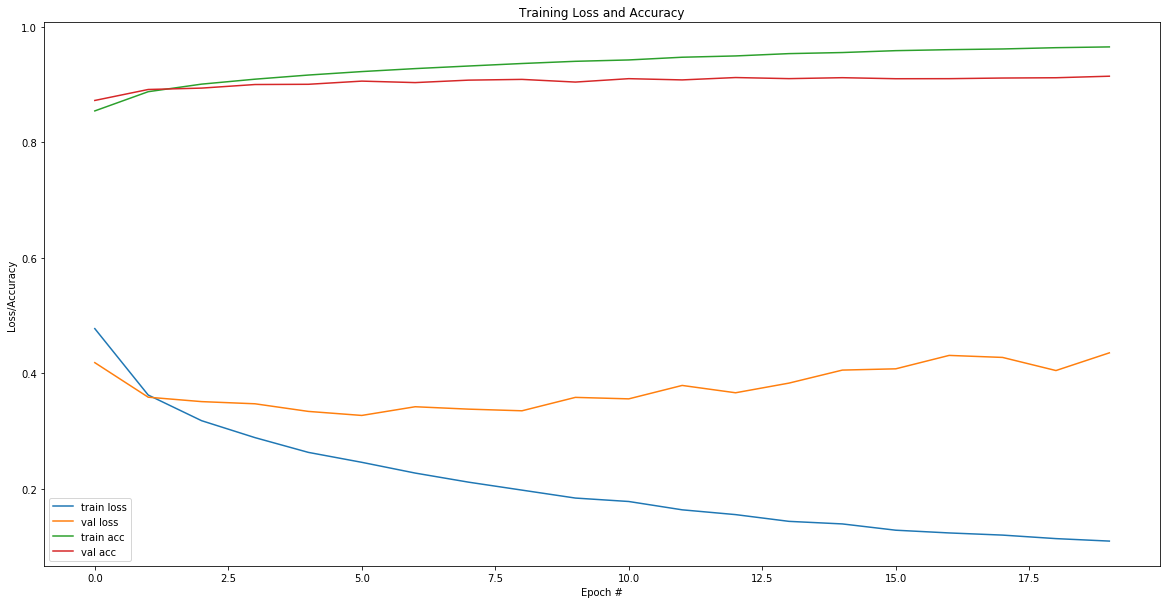

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.3525103856566208
Test Accuracy:  0.9304706




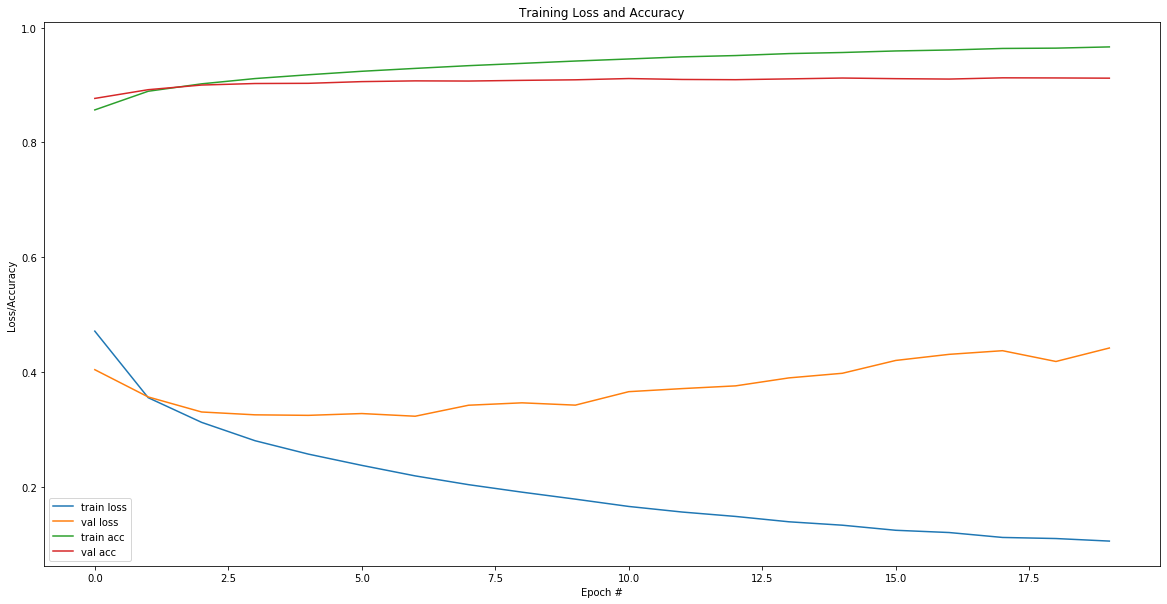

Executed model with 5 layers. 



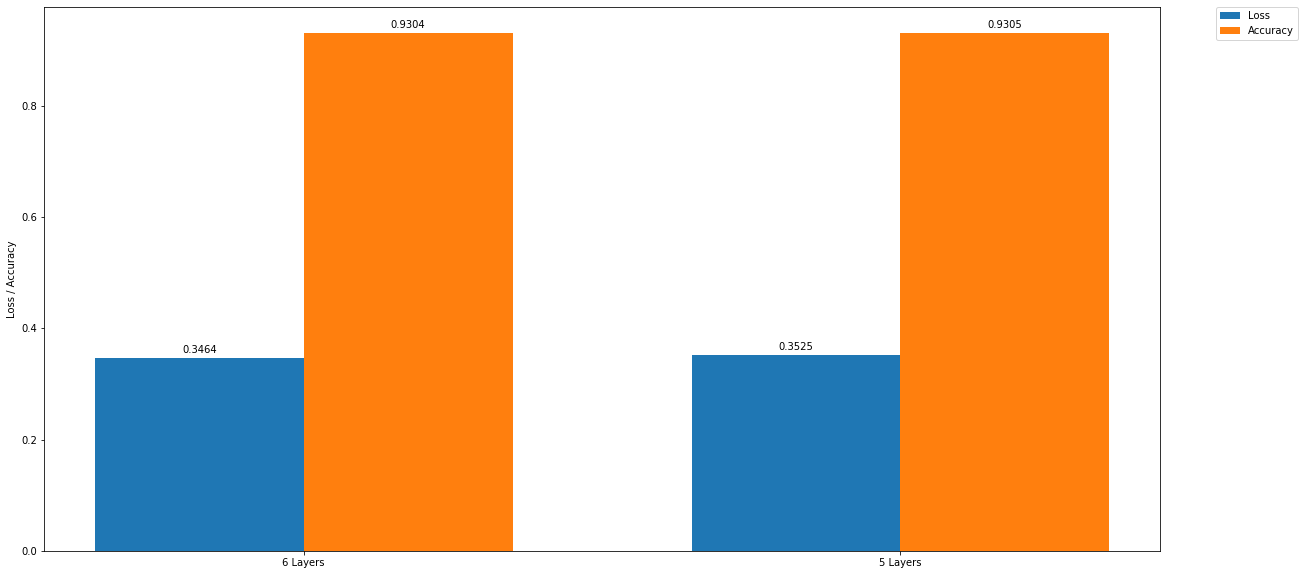

End task execution. 




Processing dropout of 0.1: 



Executing model with 6 layers:


Test Loss:  0.3095792796020995
Test Accuracy:  0.9310588




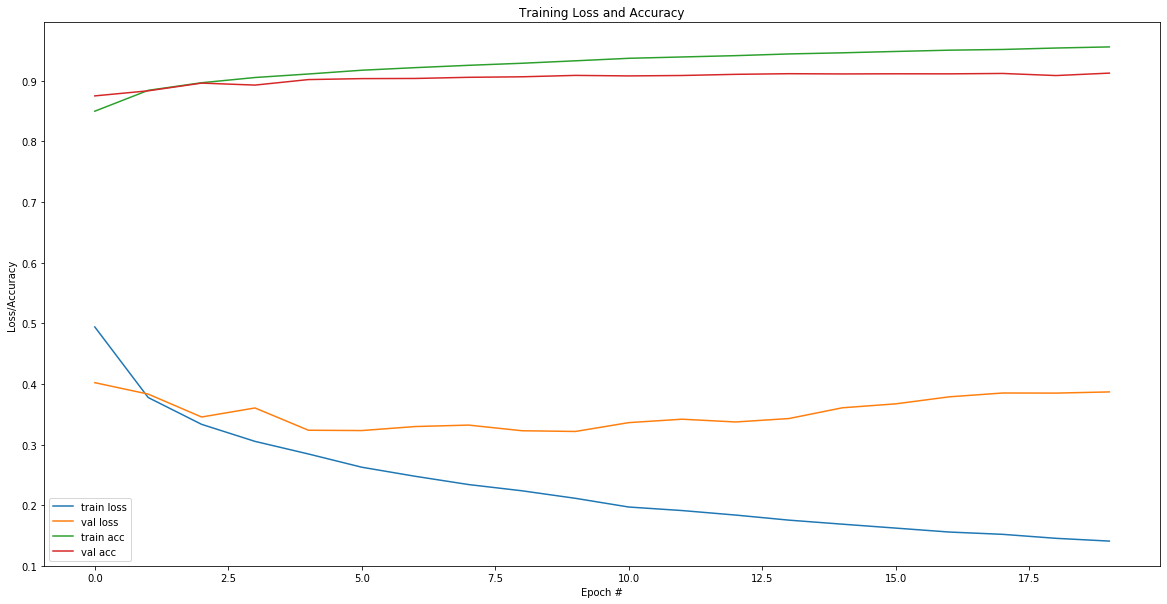

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.29478662431751623
Test Accuracy:  0.93370587




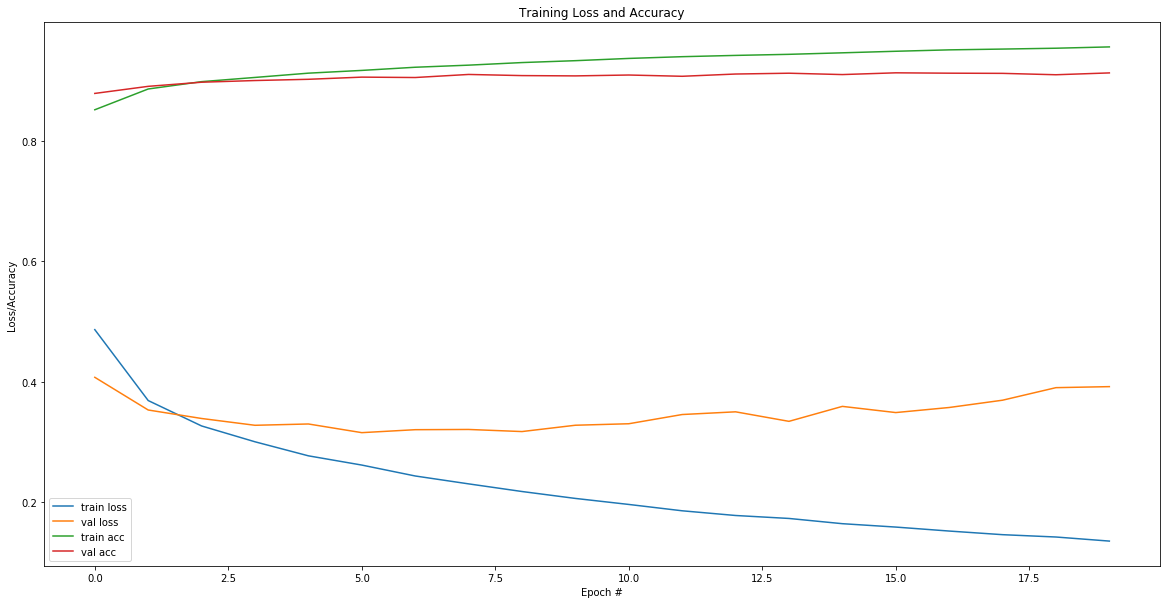

Executed model with 5 layers. 



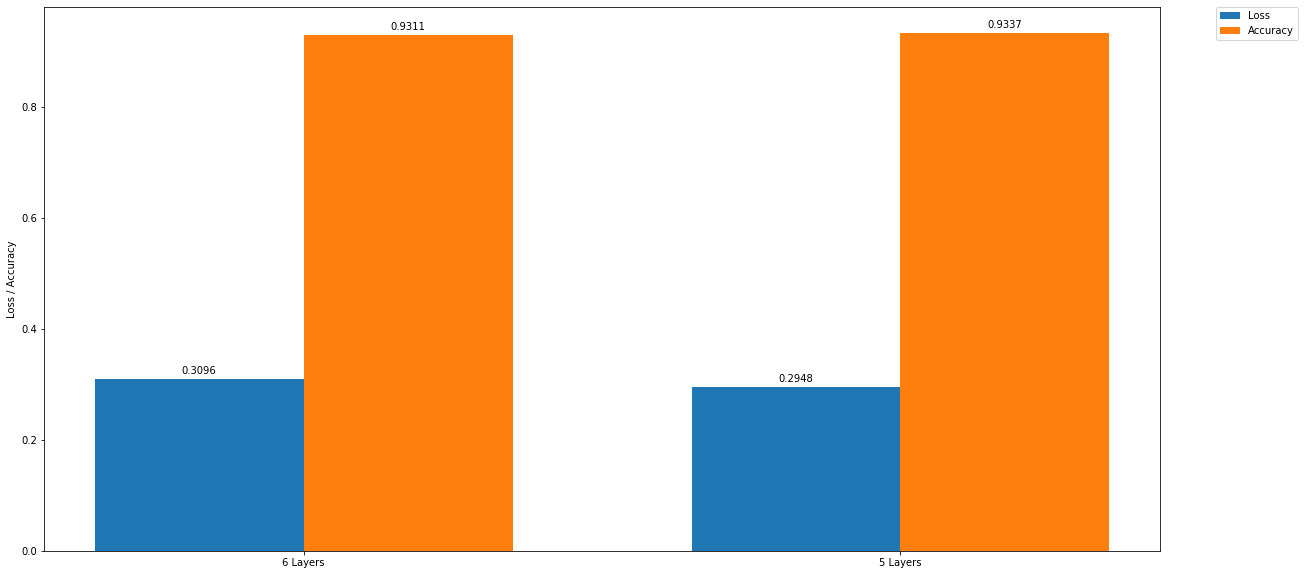

End task execution. 




Processing dropout of 0.2: 



Executing model with 6 layers:


Test Loss:  0.2498601015372859
Test Accuracy:  0.9302941




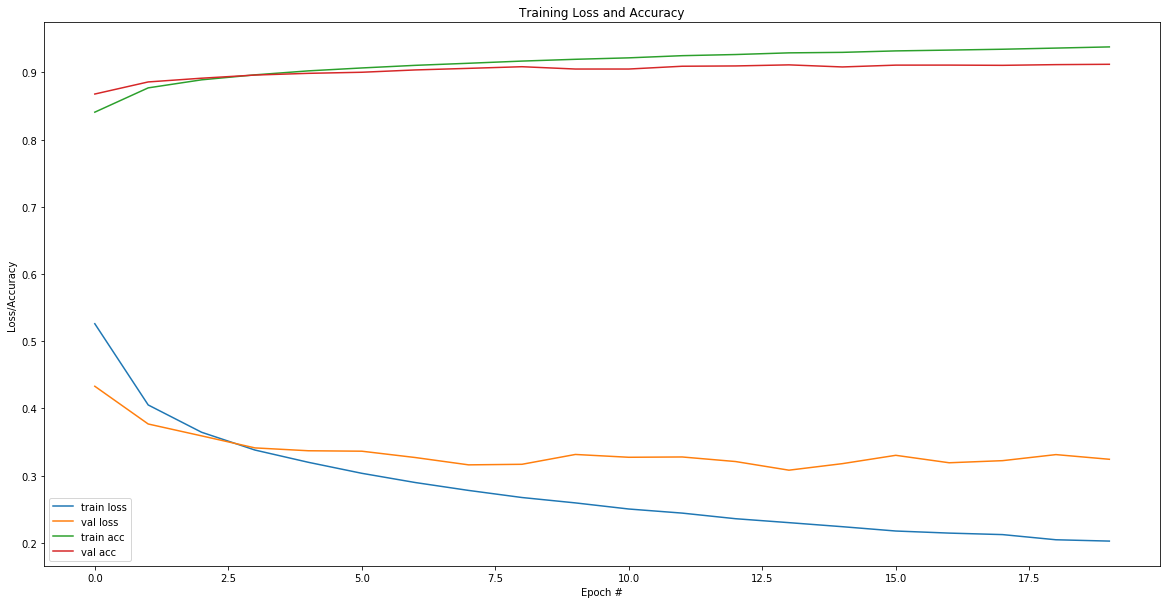

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.26320238928573536
Test Accuracy:  0.93111765




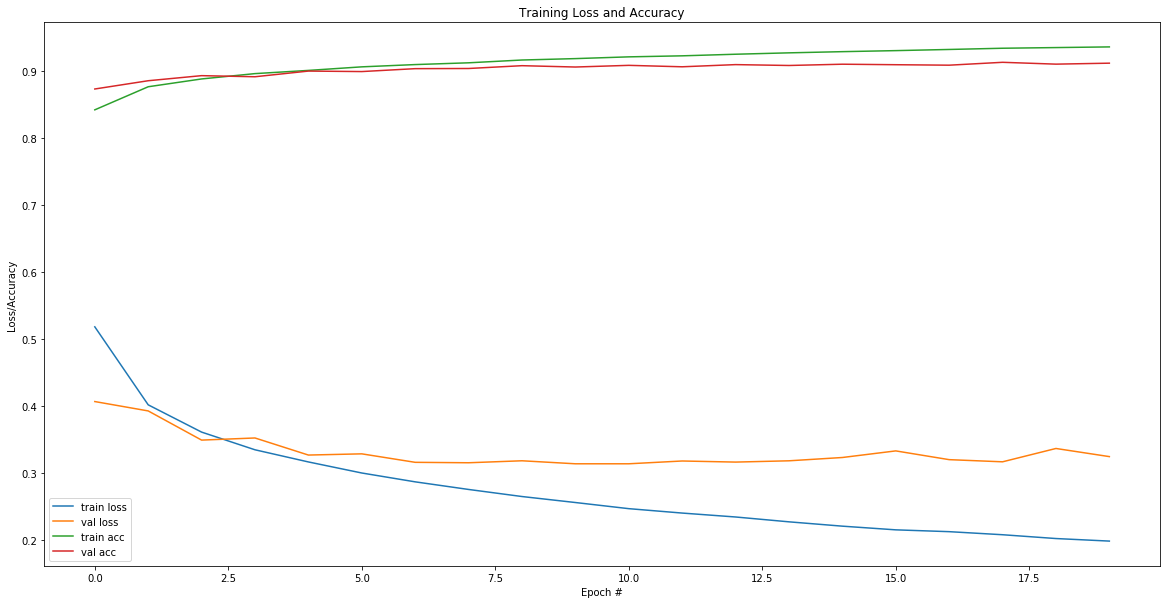

Executed model with 5 layers. 



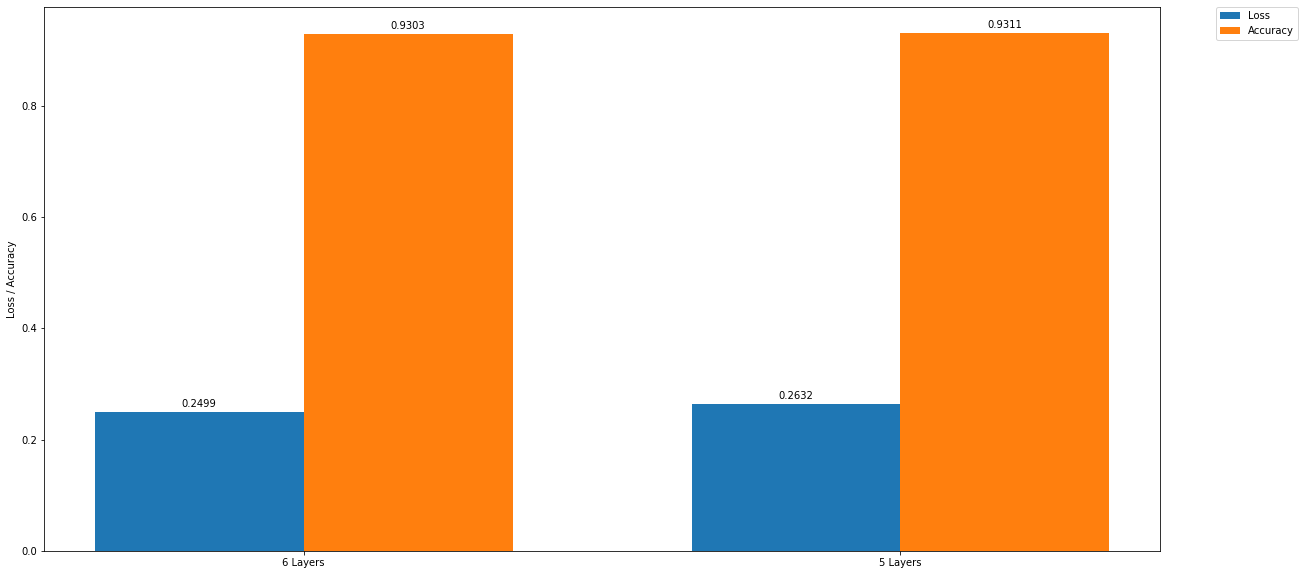

End task execution. 




Processing dropout of 0.3: 



Executing model with 6 layers:


Test Loss:  0.24389374580847867
Test Accuracy:  0.9301765




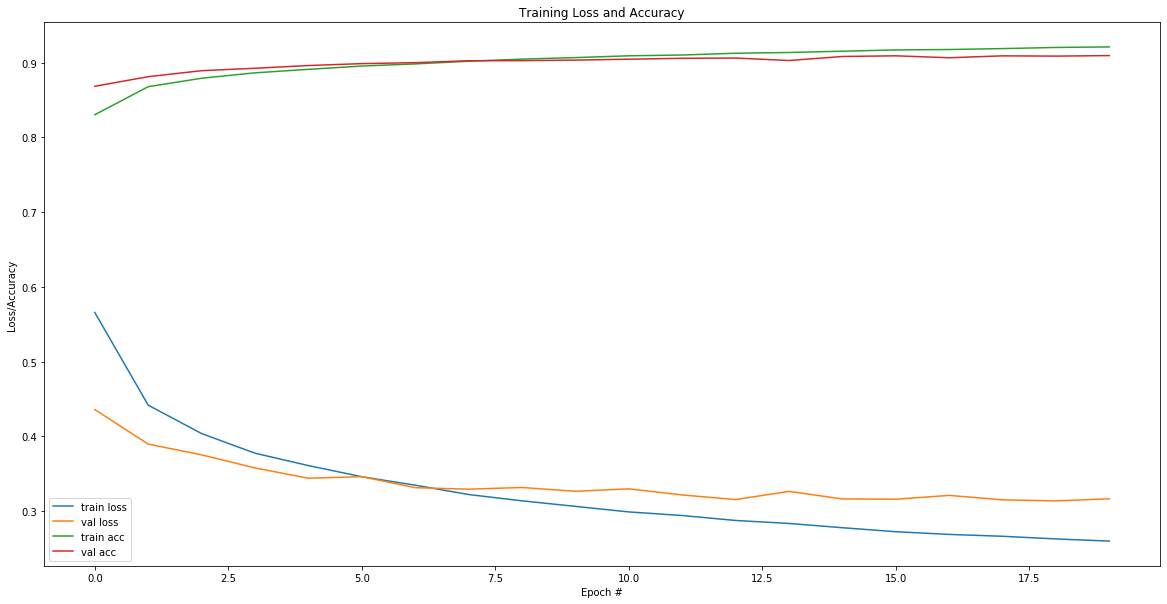

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.23728829432366524
Test Accuracy:  0.93129414




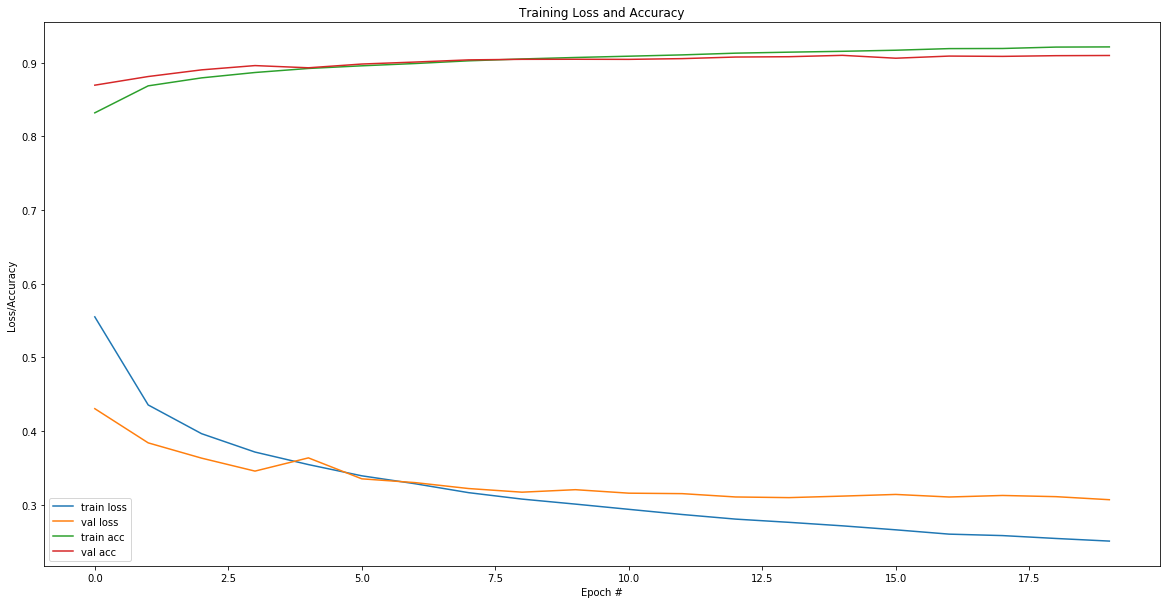

Executed model with 5 layers. 



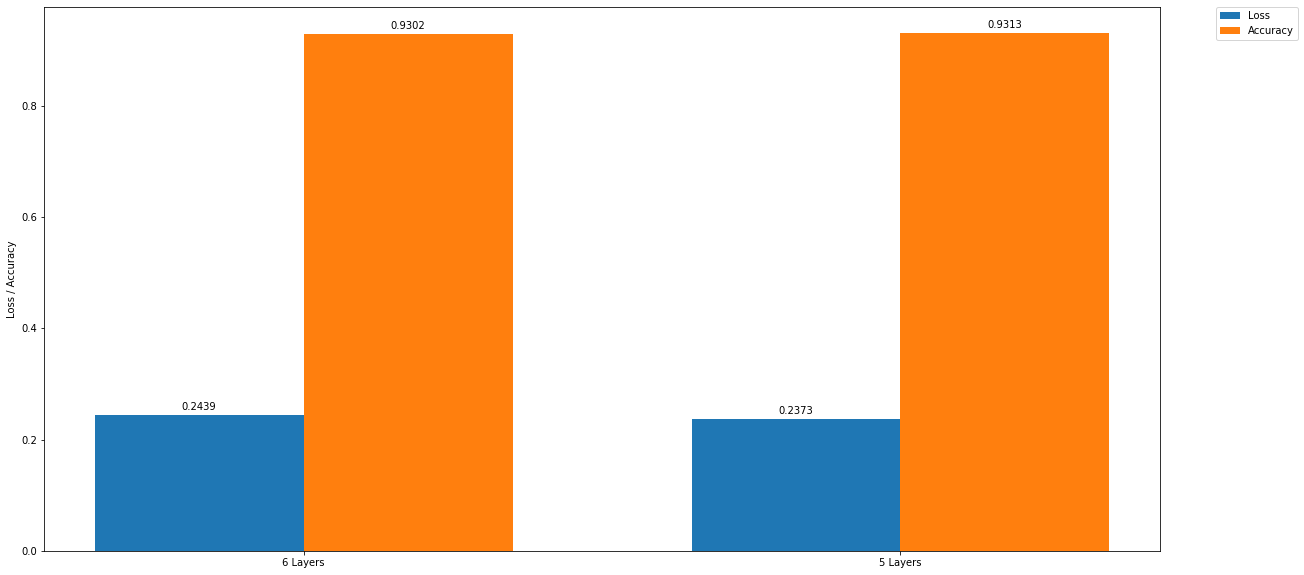

End task execution. 




Processing dropout of 0.4: 



Executing model with 6 layers:


Test Loss:  0.2601967650621253
Test Accuracy:  0.9247647




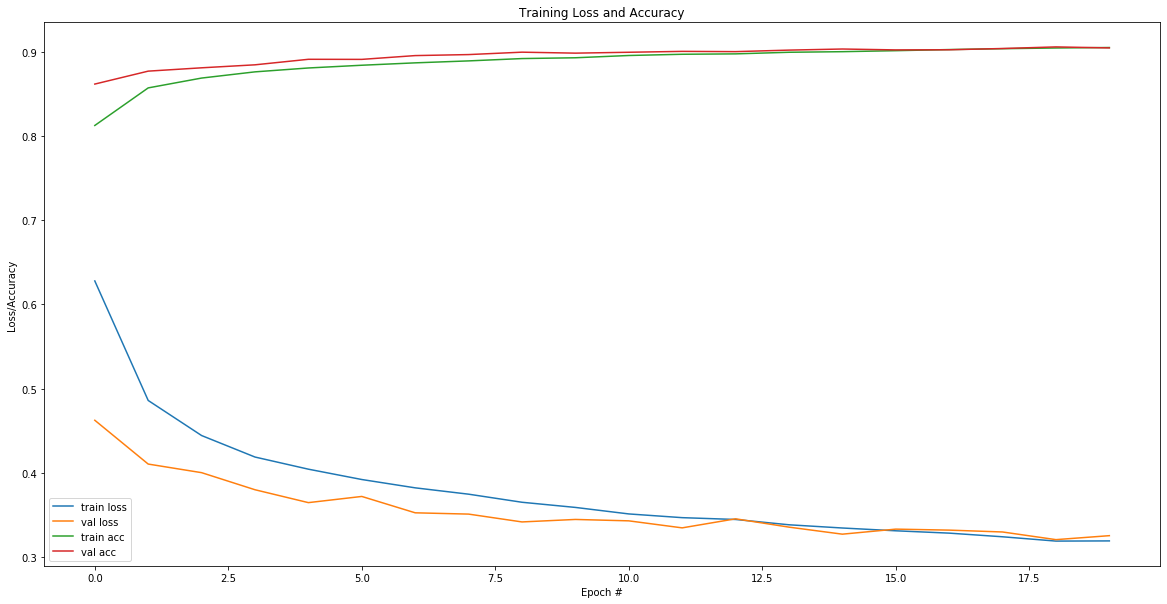

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.2560360474176705
Test Accuracy:  0.92435294




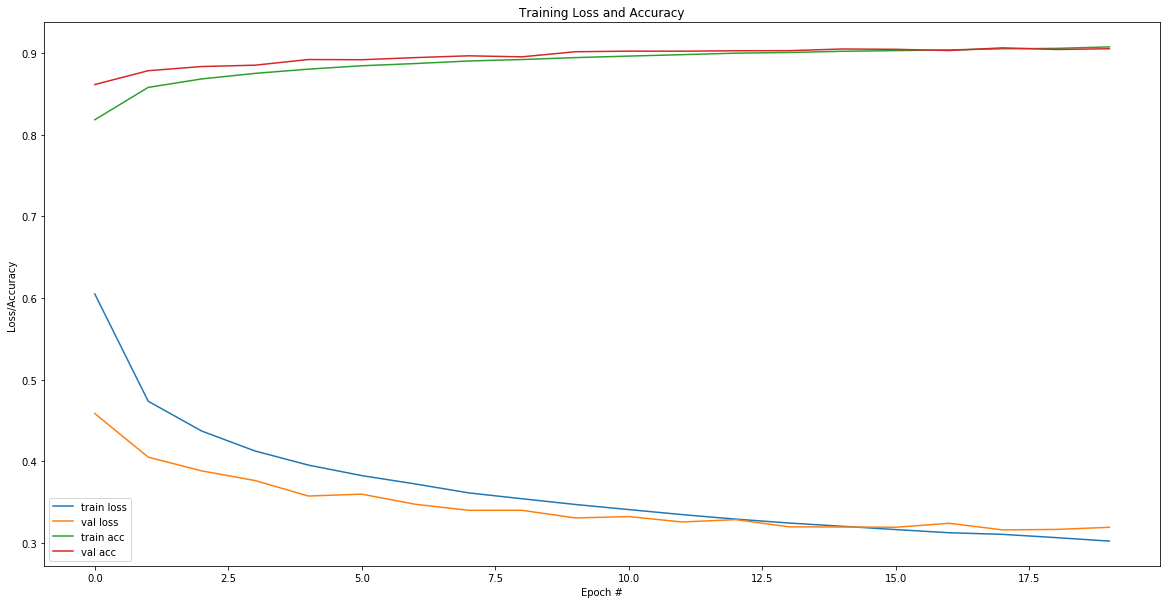

Executed model with 5 layers. 



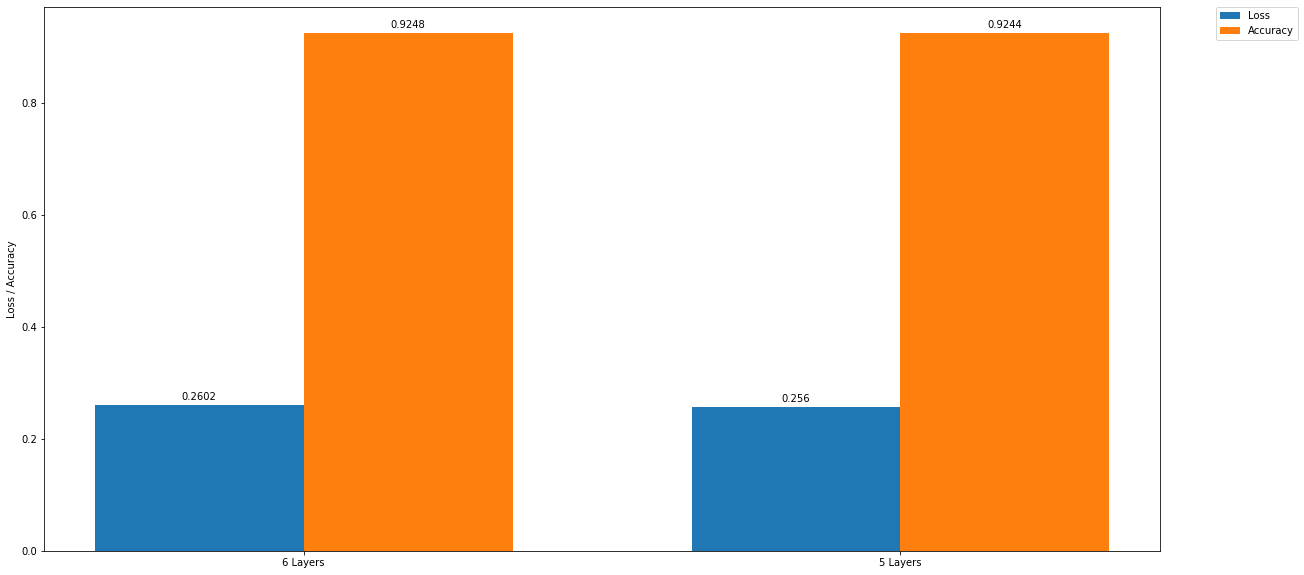

End task execution. 




Processing dropout of 0.5: 



Executing model with 6 layers:


Test Loss:  0.29177196410473655
Test Accuracy:  0.921




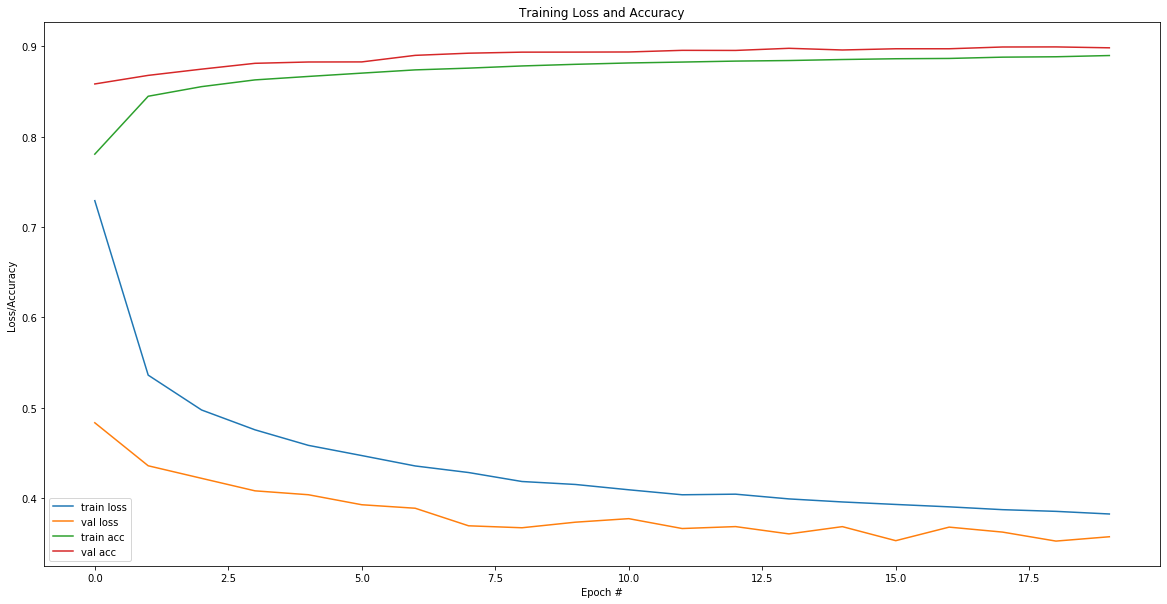

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.27109278926340974
Test Accuracy:  0.9212941




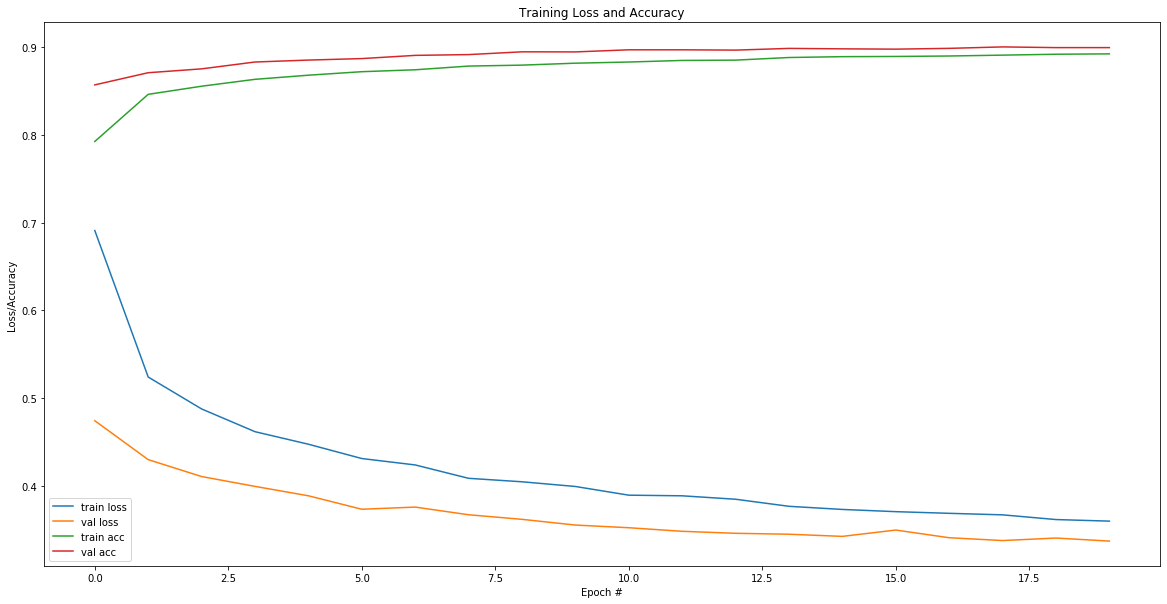

Executed model with 5 layers. 



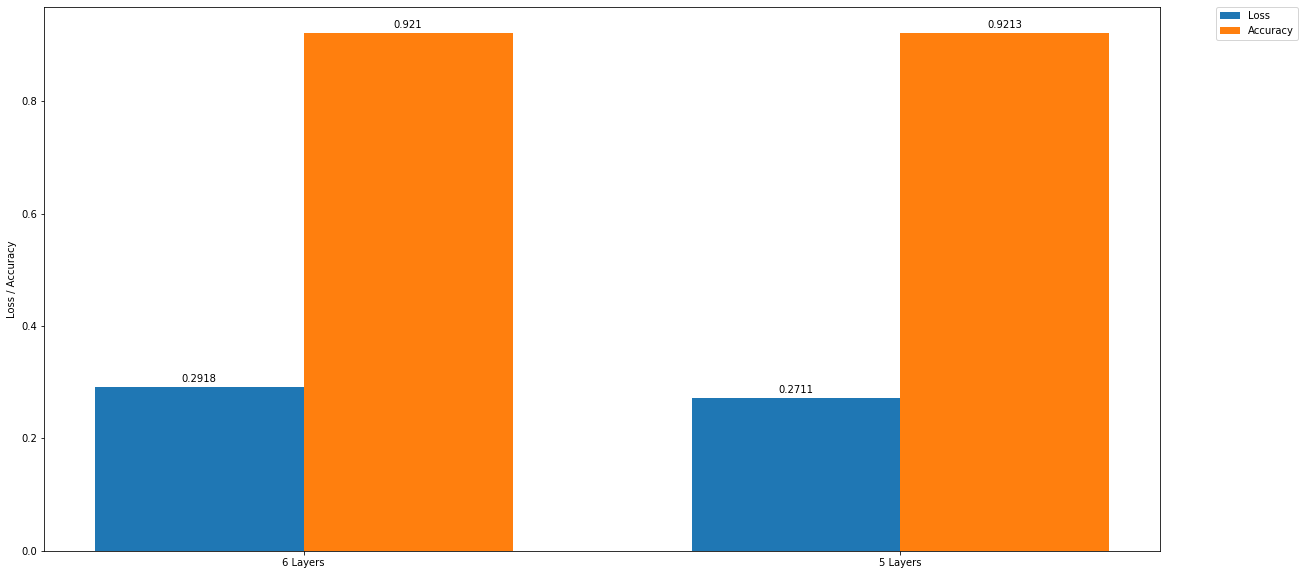

End task execution. 




Processing dropout of 0.6: 



Executing model with 6 layers:


WARNING - Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
WARNING - Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
WARNING - Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
WARNING - Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
WARNING - Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.




Test Loss:  0.33417492392133263
Test Accuracy:  0.9087059




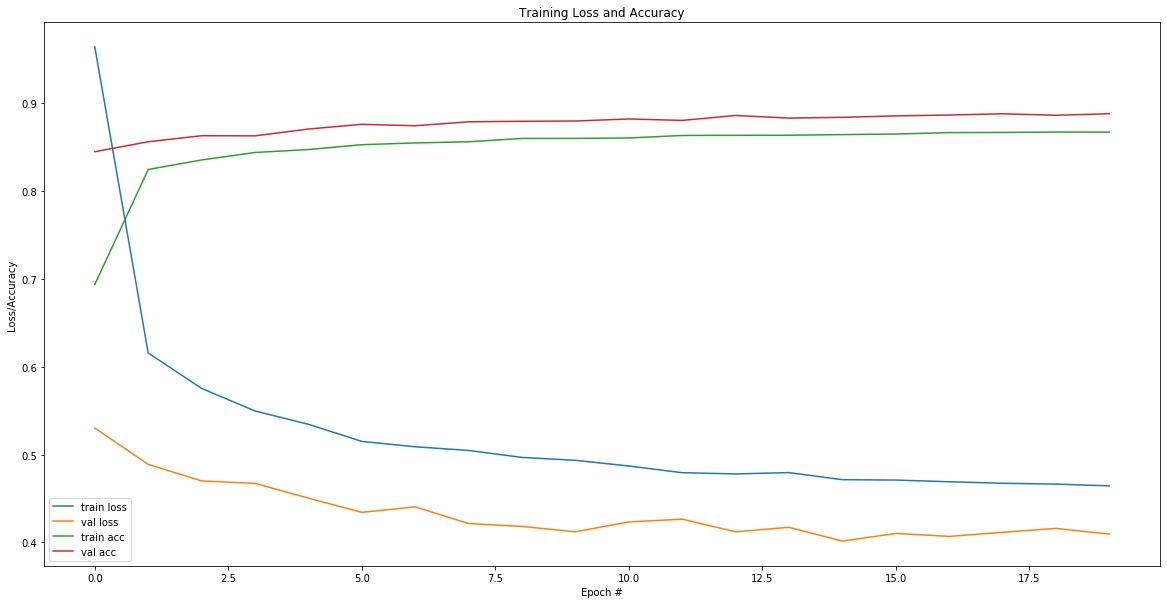

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.3026499265642727
Test Accuracy:  0.913




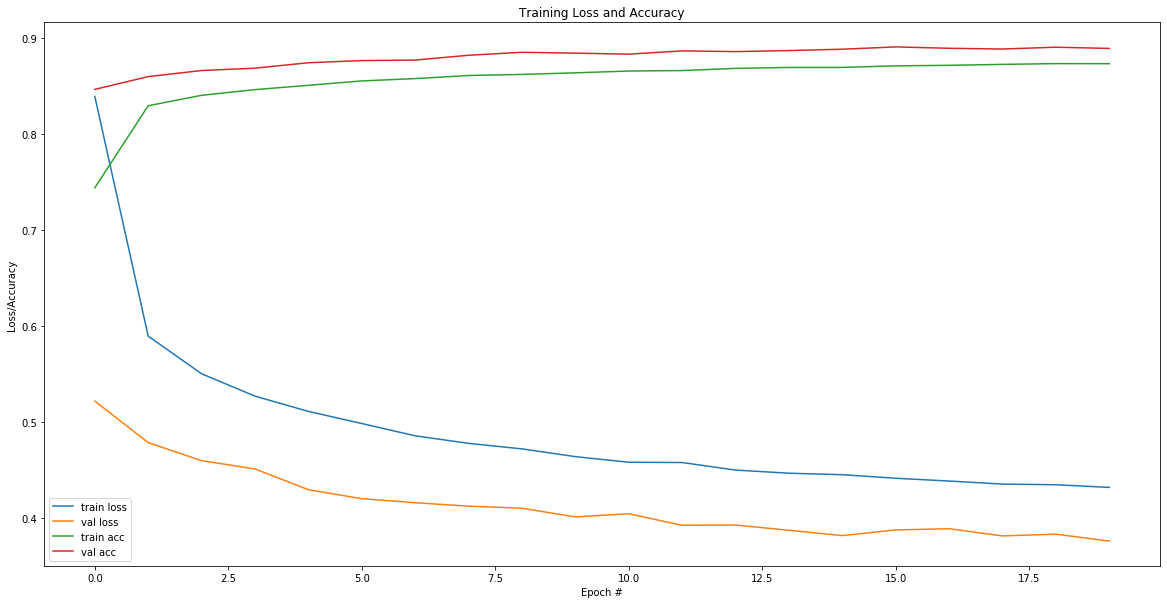

Executed model with 5 layers. 



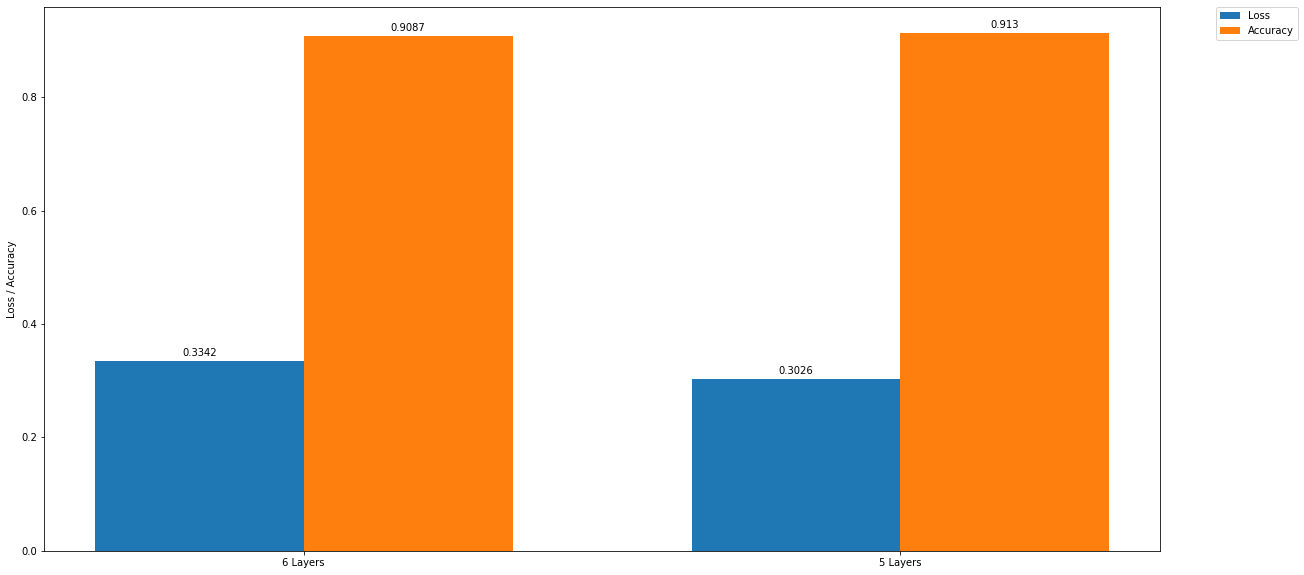

End task execution. 




Processing dropout of 0.7: 



Executing model with 6 layers:


Test Loss:  0.421277181597317
Test Accuracy:  0.89047056




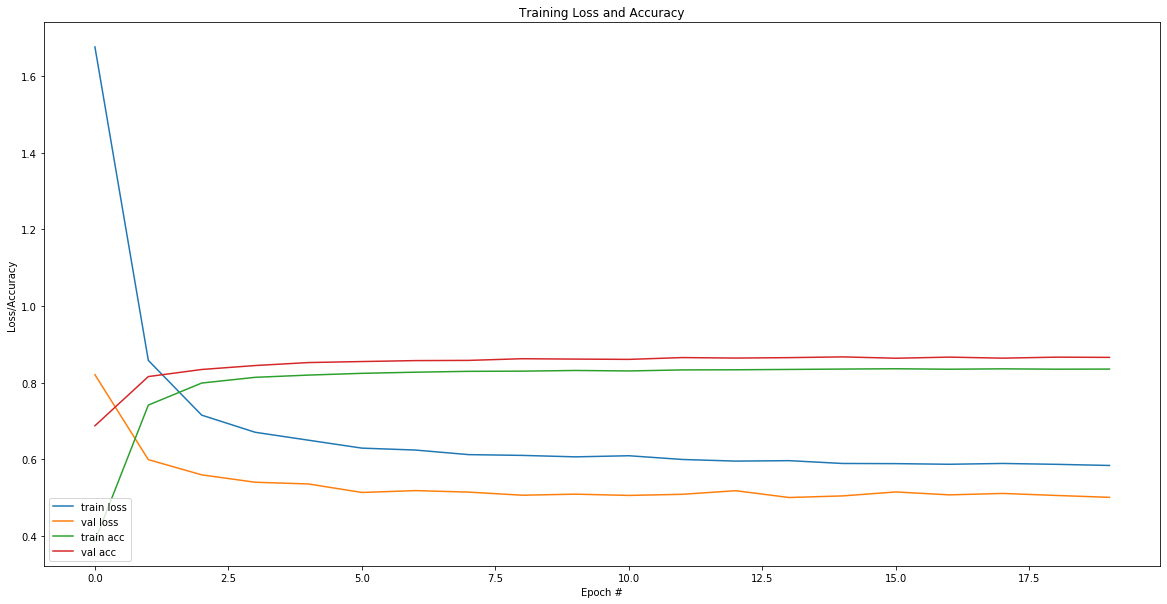

Executed model with 6 layers. 


Executing model with 5 layers:


Test Loss:  0.3622583682046217
Test Accuracy:  0.8978235




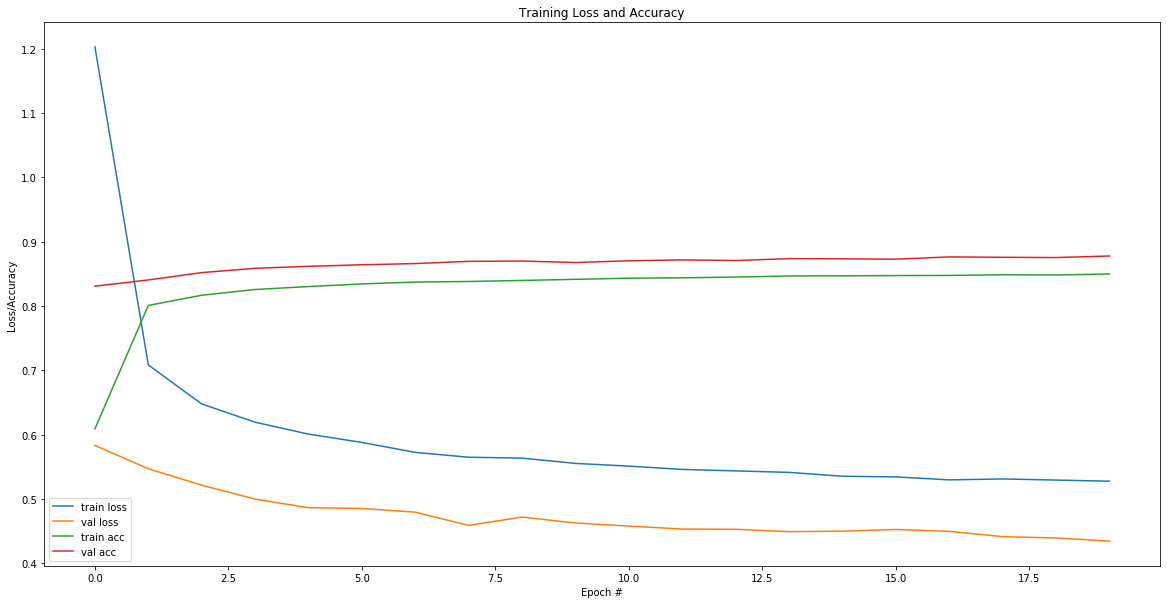

Executed model with 5 layers. 



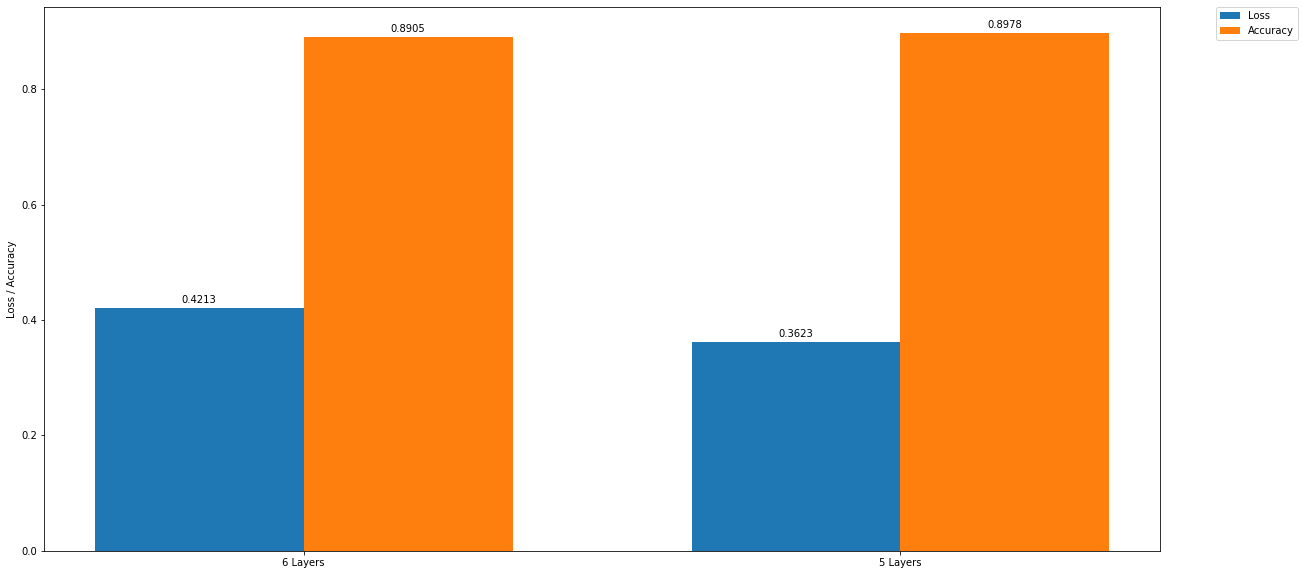

End task execution. 




In [11]:

dropouts = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for dropout in dropouts:
    tasks = []
    print("\n\nProcessing dropout of {}: \n\n".format(dropout))
    tasks.append([[1000, True, dropout], [800, True, dropout], [600, True, dropout], [400, True, dropout], [200, True, dropout]])
    tasks.append([[800, True, dropout], [600, True, dropout], [400, True, dropout], [200, True, dropout]])
    executeModels(tasks)
   
        
